# DeBERTa Fine-Tuning on CoLA with SMART and SiFT

This notebook was orginally created by Chris McCormick and Nick Ryan. We made changes for SiFT and SMART, as well as our custom BERT/DeBERTa class.

##Data and Importing Modules 

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 5.1MB/s 
     |████████████████████████████████| 3.3MB 28.4MB/s 
     |████████████████████████████████| 901kB 44.1MB/s 


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=e12b7bb698a4bab3013bccc00a6707c55877dc23043027f91f5aa77745109a12
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import pandas as pd
import requests
import io

url = "https://raw.githubusercontent.com/wangluheng328/SiFT-Project/main/Data/fourth.csv"
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')),index_col=0)
df.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [6]:
df1 = df[df['label']==1]
df0 = df[df['label']==0]
df0 = df0[:2200]
df_ori = pd.concat([df0, df1], axis = 0, join = 'inner')
df_ori = df_ori.sample(frac = 1).reset_index(drop = True)
df = df_ori[:2000]

In [7]:
df.head()

,label,tweet
0,0,beautiful (: i love living at the beach!!!! #b...
1,1,@user @user @user @user over the past 8 yrs #d...
2,1,"@user dear #democrats , djt not allowing #isla..."
3,0,chase your ð #dreams #health #music #fi...
4,0,feels like summer ð´ðð #love #like #...


In [8]:
sentences = df.tweet.values
labels = df.label.values

In [9]:
labels.sum()

1009

## Tokenization and DataLoader

In [10]:
from transformers import DebertaTokenizer
print('Loading DeBERTa tokenizer...')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

Loading DeBERTa tokenizer...


In [11]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  beautiful (: i love living at the beach!!!! #beach #loveit   
Tokenized:  ['beaut', 'iful', 'Ġ(', ':', 'Ġi', 'Ġlove', 'Ġliving', 'Ġat', 'Ġthe', 'Ġbeach', '!!!!', 'Ġ#', 'be', 'ach', 'Ġ#', 'love', 'it', 'Ġ', 'Ġ', 'Ġ']
Token IDs:  [28878, 16170, 36, 35, 939, 657, 1207, 23, 5, 4105, 32376, 849, 1610, 1488, 849, 17693, 405, 1437, 1437, 1437]


In [12]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  144


In [13]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  beautiful (: i love living at the beach!!!! #beach #loveit   
Token IDs: tensor([    1, 28878, 16170,    36,    35,   939,   657,  1207,    23,     5,
         4105, 32376,   849,  1610,  1488,   849, 17693,   405,  1437,  1437,
         1437,     2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  

In [14]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,800 training samples
  200 validation samples


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 5

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## Custom Deberta Class and Initialization

In [16]:
from transformers import DebertaForSequenceClassification, AdamW, DebertaConfig, DebertaPreTrainedModel, DebertaModel
from transformers.models.deberta.modeling_deberta import *
#from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

class CustomDebertaForClassification(DebertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        #self.bert = BertForSequenceClassification(config).from_pretrained("bert-base-uncased",num_labels = 2,output_attentions = False, output_hidden_states = False)
        self.embeddings = self.deberta.embeddings
        self.encoder = self.deberta.encoder
        self.z_steps = 0 #copied from DebertaModel source code


    def embed(self, input_ids=None, 
                    mask=None,
                    token_type_ids=None, 
                    position_ids=None, 
                    inputs_embeds=None
                    ):
        # See: BERTModel.forward
        return self.embeddings(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            mask=mask,
            inputs_embeds=inputs_embeds
        )
    
    def predict(self,embedding_output,
                attention_mask=None,
                head_mask=None,
                encoder_hidden_states=None,
                encoder_extended_attention_mask=None,
                past_key_values=None,
                use_cache=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=True): 
        encoder_outputs = self.encoder(
                                        embedding_output,
                                        attention_mask,
                                        output_hidden_states=True,
                                        output_attentions=output_attentions,
                                        return_dict=return_dict
        )
        encoded_layers = encoder_outputs[1]

        if self.z_steps > 1:
            hidden_states = encoded_layers[-2]
            layers = [self.encoder.layer[-1] for _ in range(self.z_steps)]
            query_states = encoded_layers[-1]
            rel_embeddings = self.encoder.get_rel_embedding()
            attention_mask = self.encoder.get_attention_mask(attention_mask)
            rel_pos = self.encoder.get_rel_pos(embedding_output)
            for layer in layers[1:]:
                query_states = layer(
                    hidden_states,
                    attention_mask,
                    return_att=False,
                    query_states=query_states,
                    relative_pos=rel_pos,
                    rel_embeddings=rel_embeddings,
                )
                encoded_layers.append(query_states)

        sequence_output = encoded_layers[-1]

        # if not return_dict:
        #     return (sequence_output,) + encoder_outputs[(1 if output_hidden_states else 2) :]

        outputs = BaseModelOutput(
            last_hidden_state=sequence_output,
            hidden_states=encoder_outputs.hidden_states if output_hidden_states else None,
            attentions=encoder_outputs.attentions,
        )

        

        pooled_output = self.pooler(outputs[0])
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits


In [17]:
#@title
model = CustomDebertaForClassification.from_pretrained(
    "microsoft/deberta-base",
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing CustomDebertaForClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'config']
- This IS expected if you are initializing CustomDebertaForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomDebertaForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomDebertaForClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['encoder.layer.5.attention.s

CustomDebertaForClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermedia

##Noise Function

In [18]:
from torch.nn import LayerNorm
import torch.nn.functional as F


def normalize_embed(embed):
    embed_mean = torch.mean(embed,dim=(1,2))
    embed_std = torch.std(embed, dim=(1,2))

    embed_clone = torch.clone(embed)

    for i in range(0,embed_clone.size()[0]):
        # embed_clone[i] = torch.div(torch.sub(embed_clone[i],embed_mean[i]),embed_std[i])
        embed_clone[i] = (embed_clone[i] - embed_mean[i]) / embed_std[i]
    return embed_clone, embed_mean, embed_std

def denormalize_embed(embed, embed_mean, embed_std):
    for i in range(0,embed.size()[0]):
        # embed[i] = (embed[i] - embed_mean[i]) / embed_std[i]
        embed[i] = (embed[i] * embed_std[i]) + embed_mean[i]
    return embed 

def stable_kl(logit, target, epsilon=1e-6, reduce=True):
    logit = logit.view(-1, logit.size(-1)).float()
    target = target.view(-1, target.size(-1)).float()
    bs = logit.size(0)
    p = F.log_softmax(logit, 1).exp()
    y = F.log_softmax(target, 1).exp()
    rp = -(1.0/(p + epsilon) -1 + epsilon).detach().log()
    ry = -(1.0/(y + epsilon) -1 + epsilon).detach().log()
    if reduce:
        return (p* (rp- ry) * 2).sum() / bs
    else:
        return (p* (rp- ry) * 2).sum()

def _norm_grad(grad, epsilon = 1e-6, eff_grad=None, sentence_level=False):
        if sentence_level:
            direction = grad / (grad.abs().max((-2, -1), keepdim=True)[0] + epsilon)
        else:
            direction = grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
            eff_direction = eff_grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
        return direction, eff_direction

def noise(embed, model, attention_mask, step_size, normalize=False, k=1, mean=0, std=0.01):
    if normalize == True:
        
        # LNorm = LayerNorm(embed.size(),elementwise_affine=False)
        # normalized_embed = LNorm(embed)
        normalized_embed, embed_mean, embed_std = normalize_embed(embed)
        logits = model.predict(normalized_embed,attention_mask)
        noise = torch.normal(mean=0, std=0.01,size=(normalized_embed.size()[0],normalized_embed.size()[1],normalized_embed.size()[2]))
        noise = noise.to(device)
        noise.requires_grad_()
        noised_normalized_embeddings = normalized_embed+noise
        adv_logits = model.predict(noised_normalized_embeddings, attention_mask)
        adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
        delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
        norm = delta_grad.norm()
        # if (torch.isnan(norm) or torch.isinf(norm)):
        #     return 0
        eff_delta_grad = delta_grad * step_size
        delta_grad = noise + delta_grad * step_size
        noise, eff_noise = _norm_grad(delta_grad, eff_grad=eff_delta_grad, sentence_level=0)
        noise = noise.detach()
        noised_normalized_embeddings = normalized_embed+noise
        denormalize_noised_embed = denormalize_embed(noised_normalized_embeddings,embed_mean, embed_std) 
        return denormalize_noised_embed

    else:
        logits = model.predict(embed,attention_mask)
        noise = torch.normal(mean=0, std=0.01,size=(embed.size()[0],embed.size()[1],embed.size()[2]))
        noise = noise.to(device)
        noise.requires_grad_()
        noised_embeddings = embed+noise
        adv_logits = model.predict(noised_embeddings, attention_mask)
        adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
        delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
        norm = delta_grad.norm()
        # if (torch.isnan(norm) or torch.isinf(norm)):
        #     return 0
        eff_delta_grad = delta_grad * step_size
        delta_grad = noise + delta_grad * step_size
        noise, eff_noise = _norm_grad(delta_grad, eff_grad=eff_delta_grad, sentence_level=0)
        noise = noise.detach()
        noised_embeddings = embed+noise
        return noised_embeddings



## Optimizer, Scheduler, and Some Other Training Prep

In [19]:
#@title
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

In [20]:
#@title
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                          num_warmup_steps = 0,
                          num_training_steps = total_steps
                        )

In [21]:
#@title
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
#@title
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
MODE = "SMART-adv-only"

##Training Loop with Validation

In [24]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        embed = model.embed(input_ids = b_input_ids,mask = b_input_mask)
        preds = model.predict(embedding_output = embed,attention_mask = b_input_mask)
        loss_fct = CrossEntropyLoss()
        regular_loss = loss_fct(preds.view(-1,2), b_labels.view(-1))
        loss_list = [regular_loss]
        if MODE in ["SMART-adv-only", "SIFT"]:
          normalise = True if MODE == "SIFT" else False
          noised_embeddings = noise(embed, model, b_input_mask, 1e-3, normalize=normalise, k=1)
          adv_logits = model.predict(noised_embeddings, b_input_mask)

          adv_loss = stable_kl(preds.view(-1,2), adv_logits.view(-1,2))
          loss_list.append(adv_loss)
        loss = sum(loss_list)
        # END MODEL
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)   

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of    360.    Elapsed: 0:00:23.
  Batch    80  of    360.    Elapsed: 0:00:46.
  Batch   120  of    360.    Elapsed: 0:01:09.
  Batch   160  of    360.    Elapsed: 0:01:32.
  Batch   200  of    360.    Elapsed: 0:01:55.
  Batch   240  of    360.    Elapsed: 0:02:18.
  Batch   280  of    360.    Elapsed: 0:02:41.
  Batch   320  of    360.    Elapsed: 0:03:04.

  Average training loss: 0.52
  Training epcoh took: 0:03:26

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
  Validation took: 0:00:03

Training complete!
Total training took 0:03:29 (h:mm:ss)


Let's view the summary of the training process.

In [25]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.52,0.18,0.93,0:03:26,0:00:03


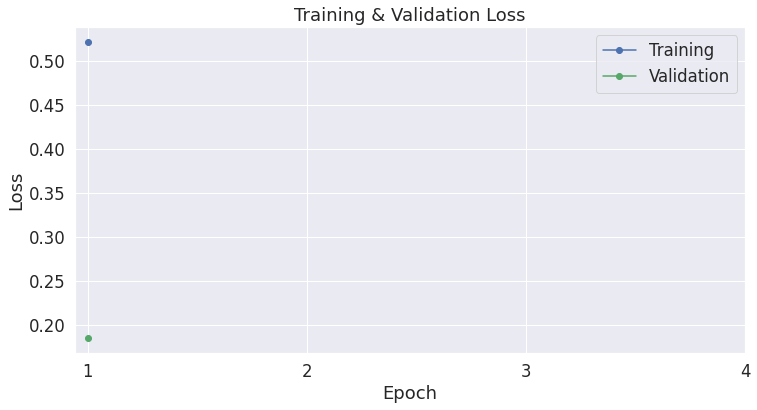

In [26]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##Performance On Test Set

### Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [27]:
import pandas as pd

df = df_ori[2000:]
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.tweet.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 256,  
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   ) 
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
 
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,442



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


###Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [28]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,442 test sentences...
    DONE.


In [29]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 1233 of 2442 (50.49%)


In [30]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

print(sum(flat_predictions == flat_true_labels)/len(flat_predictions))

0.9058149058149059


## Test on UCI with/without Further Training

### Data

In [31]:
url = "https://raw.githubusercontent.com/wangluheng328/SiFT-Project/main/Data/amazon_cells_labelled.txt"
download = requests.get(url).content
df_amazon = pd.read_csv(io.StringIO(download.decode('utf-8')),delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df_amazon.head()

,Sentence,Label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [32]:
url = "https://raw.githubusercontent.com/wangluheng328/SiFT-Project/main/Data/yelp_labelled.txt"
download = requests.get(url).content
df_yelp = pd.read_csv(io.StringIO(download.decode('utf-8')),delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df_yelp.head()

,Sentence,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [33]:
url = "https://raw.githubusercontent.com/wangluheng328/SiFT-Project/main/Data/imdb_labelled.txt"
download = requests.get(url).content
df_imdb = pd.read_csv(io.StringIO(download.decode('utf-8')),delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df_imdb.head()

,Sentence,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [34]:
uci = pd.concat([df_imdb, df_amazon, df_yelp], axis = 0, join = 'inner')
uci = uci.sample(frac = 1).reset_index(drop = True)
uci.head()

,Sentence,Label
0,"It's close to my house, it's low-key, non-fanc...",1
1,If you stay in Vegas you must get breakfast he...,1
2,clipping this to your belt will deffinitely ma...,1
3,This is the phone to get for 2005.... I just b...,1
4,"i felt insulted and disrespected, how could yo...",0


### Further Training

In [35]:
uci_further = uci[:270]
uci_test = uci[270:]

In [36]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

from transformers import get_linear_schedule_with_warmup
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                          num_warmup_steps = 0,
                          num_training_steps = total_steps
                        )


sentences = uci_further.Sentence.values
labels = uci_further.Label.values

input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))



from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 5

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )



import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        embed = model.embed(input_ids = b_input_ids,mask = b_input_mask)
        preds = model.predict(embedding_output = embed,attention_mask = b_input_mask)
        loss_fct = CrossEntropyLoss()
        regular_loss = loss_fct(preds.view(-1,2), b_labels.view(-1))
        loss_list = [regular_loss]
        if MODE in ["SMART-adv-only", "SIFT"]:
          normalise = True if MODE == "SIFT" else False
          noised_embeddings = noise(embed, model, b_input_mask, 1e-3, normalize=normalise, k=1)
          adv_logits = model.predict(noised_embeddings, b_input_mask)

          adv_loss = stable_kl(preds.view(-1,2), adv_logits.view(-1,2))
          loss_list.append(adv_loss)
        loss = sum(loss_list)
        # END MODEL
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)   

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  243 training samples
   27 validation samples

======== Epoch 1 / 3 ========
Training...
  Batch    40  of     49.    Elapsed: 0:00:23.

  Average training loss: 0.82
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.63
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     49.    Elapsed: 0:00:23.

  Average training loss: 0.52
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.76
  Validation took: 0:00:00

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     49.    Elapsed: 0:00:23.

  Average training loss: 0.68
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.69
  Validation took: 0:00:00

Training complete!
Total training took 0:01:24 (h:mm:ss)


### Testing on The Remaining

In [37]:
import pandas as pd

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(uci_test.shape[0]))

# Create sentence and label lists
sentences = uci_test.Sentence.values
labels = uci_test.Label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 256,  
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   ) 
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
 
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,478



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [38]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  #print(logits.sum())
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,478 test sentences...
    DONE.


In [39]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

print(np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels))

0.8087167070217918
